In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.signal import savgol_filter
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression, RidgeClassifier, RidgeClassifierCV, PassiveAggressiveClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import RFE
from tqdm import tqdm

In [2]:
seed = 12

In [3]:
def scalling(X_train, X_val, X_test, X_train_val, X_mix1, X_mix2, scaler):
    
    scaler.fit(X_train._get_numeric_data())
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    X_train_val = pd.DataFrame(scaler.transform(X_train_val), columns=X_train_val.columns)
    X_mix1 = pd.DataFrame(scaler.transform(X_mix1), columns=X_mix1.columns)
    X_mix2 = pd.DataFrame(scaler.transform(X_mix2), columns=X_mix2.columns)
    
    return X_train, X_val, X_test, X_train_val, X_mix1, X_mix2

In [4]:
def smooth(X_train, X_val, X_test, X_train_val, X_mix1, X_mix2, deriv=1, window_length=3, polyorder=1):

    X_train = pd.DataFrame(savgol_filter(X_train, deriv=deriv, window_length=window_length,
                            polyorder=polyorder, axis=0), columns=X_train.columns)
    X_val =  pd.DataFrame(savgol_filter(X_val, deriv=deriv, window_length=window_length,
                            polyorder=polyorder, axis=0), columns=X_val.columns)
    X_test = pd.DataFrame(savgol_filter(X_test, deriv=deriv, window_length=window_length,
                            polyorder=polyorder, axis=0), columns=X_test.columns)
    X_train_val = pd.DataFrame(savgol_filter(X_train_val, deriv=deriv, window_length=window_length,
                            polyorder=polyorder, axis=0), columns=X_train_val.columns)
    X_mix1 = pd.DataFrame(savgol_filter(X_mix1, deriv=deriv, window_length=window_length,
                            polyorder=polyorder, axis=0), columns=X_mix1.columns)
    X_mix2 = pd.DataFrame(savgol_filter(X_mix2, deriv=deriv, window_length=window_length,
                            polyorder=polyorder, axis=0), columns=X_mix2.columns)


    return X_train, X_val, X_test, X_train_val, X_mix1, X_mix2

In [5]:
def get_best_clf(clfs, X_train, X_val, y_train, y_val):
    
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_val, y_val) 
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'Accuracy': accuracy})
        
    print(pd.DataFrame(results).set_index('clf').sort_values(by='Accuracy', ascending=False))
    return best_clf, best_clf_name, best_accuracy

In [6]:
def print_val_scores(scores, extra_info=False):
    print(f'Cross validation scores: mean: {np.mean(scores):.3f}, all: {[round(score, 3) for score in scores]}')
    if extra_info:
        print(f'(std: {np.std(scores):.3f}, min: {min(scores):.3f}, max: {max(scores):.3f})')

In [7]:
def print_search_results(est):

    means = est.cv_results_['mean_test_score']
    stds = est.cv_results_['std_test_score']
    params_all = est.cv_results_['params']
    print('\nScores on validation set:')
    for mean_score, std_score, params in zip(means, stds, params_all):
        print(f'{mean_score:.3f} (+/-{(std_score * 2):.3f}) for {params}\n')
        
    print('Best parameters set found on validation set:', est.best_params_)
    print(f'Best validation score: {est.best_score_:.3f}')

In [8]:
df = pd.read_csv('../../data/raw/single_odor.csv')
df_mix1 = pd.read_csv('../../data/raw/mix_odor_1.csv')
df_mix2 = pd.read_csv('../../data/raw/mix_odor_2.csv')

In [9]:
df = df.iloc[:,:-3]
df_mix1 = df_mix1.iloc[:,:-3]
df_mix2 = df_mix2.iloc[:,:-3]

In [10]:
df_mix1 = df_mix1[df_mix1['label']=='3-Mix1']
df_mix2 = df_mix2[df_mix2['label']=='3-Mix2']

In [11]:
X = df.drop('label', axis=1)
y = df['label']

X_mix1 = df_mix1.drop('label', axis=1)
y_mix1 = df_mix1['label']

X_mix2 = df_mix2.drop('label', axis=1)
y_mix2 = df_mix2['label']

In [12]:
y.value_counts(normalize=True)

2-Hex      0.137860
6-Ger      0.136831
5-Lem      0.129630
4-Rose     0.129630
7-Cit      0.120370
8-Van      0.118313
1-Benz     0.116255
3-Ethyl    0.111111
Name: label, dtype: float64

In [13]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [14]:
ros = SVMSMOTE(sampling_strategy='all', random_state=seed)
X_train_val, y_train_val = ros.fit_resample(X_train_val, y_train_val)
X_test, y_test = ros.fit_resample(X_test, y_test)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=3/4, random_state=seed,
                                                  stratify=y_train_val)

In [16]:
y_train_val.value_counts(normalize=True)

7-Cit      0.125
4-Rose     0.125
3-Ethyl    0.125
5-Lem      0.125
2-Hex      0.125
8-Van      0.125
1-Benz     0.125
6-Ger      0.125
Name: label, dtype: float64

In [17]:
y_test.value_counts(normalize=True)

5-Lem      0.125581
4-Rose     0.125581
3-Ethyl    0.125581
1-Benz     0.125581
6-Ger      0.125581
8-Van      0.125581
2-Hex      0.125581
7-Cit      0.120930
Name: label, dtype: float64

In [18]:
#X_train, X_val, X_test, X_train_val, X_mix1, X_mix2 = scalling(X_train, X_val, X_test, X_train_val, X_mix1, X_mix2, MinMaxScaler())

In [19]:
#X_train, X_val, X_test, X_train_val, X_mix1, X_mix2 = smooth(X_train, X_val, X_test, X_train_val, X_mix1, X_mix2, deriv=1, window_length=3, polyorder=1)

In [20]:
clfs = [
    ('RandomForestClassifier', RandomForestClassifier(random_state=seed)), 
    ('ExtraTreesClassifier', ExtraTreesClassifier(random_state=seed)),
    ('BaggingClassifier', BaggingClassifier(random_state=seed)),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=seed)),
    ('AdaBoostClassifier', AdaBoostClassifier(random_state=seed)),
    ('ExtraTreeClassifier', ExtraTreeClassifier(random_state=seed)),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=seed)),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('LabelPropagation', LabelPropagation()),
    ('LabelSpreading', LabelSpreading()),
    ('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis()),
    ('Perceptron', Perceptron(random_state=seed)),
    ('SGDClassifier', SGDClassifier(random_state=seed)),
    ('LogisticRegression', LogisticRegression(random_state=seed)),
    ('RidgeClassifier', RidgeClassifier(random_state=seed)),
    ('PassiveAggressiveClassifier', PassiveAggressiveClassifier(random_state=seed)),
    ('SVC', SVC(random_state=seed)),
    ('LinearSVC', LinearSVC(random_state=seed)),
    ('NearestCentroid', NearestCentroid()),
    ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
    ('GaussianNB', GaussianNB()),
    ('BernoulliNB', BernoulliNB()),
    ('CalibratedClassifierCV', CalibratedClassifierCV()),
    ('DummyClassifier', DummyClassifier(random_state=seed)),
]

In [21]:
get_best_clf(clfs, X_train, X_val, y_train, y_val)

/Users/samuellederman/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/samuellederman/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/samuellederman/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/samuellederman/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to th

                               Accuracy
clf                                    
ExtraTreesClassifier           0.845794
RandomForestClassifier         0.813084
GradientBoostingClassifier     0.752336
BaggingClassifier              0.714953
KNeighborsClassifier           0.710280
LogisticRegression             0.672897
SVC                            0.654206
DecisionTreeClassifier         0.649533
ExtraTreeClassifier            0.635514
CalibratedClassifierCV         0.588785
GaussianNB                     0.560748
LinearDiscriminantAnalysis     0.546729
BernoulliNB                    0.542056
RidgeClassifier                0.528037
NearestCentroid                0.495327
PassiveAggressiveClassifier    0.415888
AdaBoostClassifier             0.369159
LinearSVC                      0.364486
Perceptron                     0.341121
QuadraticDiscriminantAnalysis  0.294393
SGDClassifier                  0.252336
LabelSpreading                 0.126168
LabelPropagation               0.126168


/Users/samuellederman/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(ExtraTreesClassifier(random_state=12),
 'ExtraTreesClassifier',
 0.8457943925233645)

In [22]:
clf = ExtraTreesClassifier(random_state=seed)

rfe = RFE(estimator=clf, n_features_to_select=95)
rfe.fit(X_train, y_train)
X_train = X_train.iloc[:,rfe.support_]
X_val = X_val.iloc[:,rfe.support_]
X_test = X_test.iloc[:,rfe.support_]
X_train_val = X_train_val.iloc[:,rfe.support_]
X_mix1 = X_mix1.iloc[:,rfe.support_]
X_mix2 = X_mix2.iloc[:,rfe.support_]

In [23]:
skf = StratifiedKFold(n_splits=5)

scores = cross_val_score(ExtraTreesClassifier(random_state=42), 
                         X_train_val,
                         y_train_val,
                         cv=skf)

print_val_scores(scores, extra_info=True)

Cross validation scores: mean: 0.825, all: [0.814, 0.83, 0.819, 0.807, 0.854]
(std: 0.016, min: 0.807, max: 0.854)


In [24]:
scores = cross_val_score(RandomForestClassifier(random_state=seed), 
                         X_train_val,
                         y_train_val,
                         cv=skf)

print_val_scores(scores, extra_info=True)

Cross validation scores: mean: 0.794, all: [0.779, 0.807, 0.784, 0.807, 0.795]
(std: 0.012, min: 0.779, max: 0.807)


In [25]:
scores = cross_val_score(GradientBoostingClassifier(random_state=seed), 
                         X_train_val,
                         y_train_val,
                         cv=skf)

print_val_scores(scores, extra_info=True)

Cross validation scores: mean: 0.772, all: [0.797, 0.766, 0.737, 0.778, 0.784]
(std: 0.020, min: 0.737, max: 0.797)


In [26]:
params_dict_clf = [{'n_estimators': np.arange(1, 1000, 1),
                    'max_features': np.arange(0.01, 1, 0.01),
                    'max_depth': np.arange(1, 1000, 1)}]


clf_rgs = RandomizedSearchCV(ExtraTreesClassifier(random_state=seed), 
                             params_dict_clf, 
                             cv=skf,
                             random_state=seed,
                             n_iter=100)

clf_rgs.fit(X_train_val, y_train_val)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=ExtraTreesClassifier(random_state=12), n_iter=100,
                   param_distributions=[{'max_depth': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,...
       911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923,
       924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936,
       937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949,
       950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962,
       963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975,
       976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988,
       989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999])}],
                   random_state=12)

In [27]:
print_search_results(clf_rgs)


Scores on validation set:
0.822 (+/-0.040) for {'n_estimators': 109, 'max_features': 0.76, 'max_depth': 379}

0.822 (+/-0.046) for {'n_estimators': 52, 'max_features': 0.98, 'max_depth': 925}

0.825 (+/-0.031) for {'n_estimators': 814, 'max_features': 0.23, 'max_depth': 579}

0.832 (+/-0.030) for {'n_estimators': 546, 'max_features': 0.11, 'max_depth': 109}

0.821 (+/-0.023) for {'n_estimators': 199, 'max_features': 0.7000000000000001, 'max_depth': 211}

0.831 (+/-0.040) for {'n_estimators': 650, 'max_features': 0.9400000000000001, 'max_depth': 633}

0.824 (+/-0.030) for {'n_estimators': 639, 'max_features': 0.19, 'max_depth': 293}

0.825 (+/-0.032) for {'n_estimators': 990, 'max_features': 0.7000000000000001, 'max_depth': 543}

0.819 (+/-0.032) for {'n_estimators': 934, 'max_features': 0.86, 'max_depth': 118}

0.829 (+/-0.020) for {'n_estimators': 966, 'max_features': 0.09, 'max_depth': 617}

0.831 (+/-0.024) for {'n_estimators': 557, 'max_features': 0.3, 'max_depth': 95}

0.821 (+/-

In [32]:
clf = ExtraTreesClassifier(random_state=seed, n_estimators=151, max_features=0.06, max_depth=293)
clf.fit(X_train_val, y_train_val)
accuracy = clf.score(X_test, y_test)
accuracy

0.8697674418604651

              precision    recall  f1-score   support

      1-Benz       0.96      0.93      0.94        27
       2-Hex       0.83      0.89      0.86        27
     3-Ethyl       0.93      0.93      0.93        27
      4-Rose       0.83      0.93      0.88        27
       5-Lem       0.82      0.67      0.73        27
       6-Ger       0.88      0.81      0.85        27
       7-Cit       0.81      0.81      0.81        26
       8-Van       0.90      1.00      0.95        27

    accuracy                           0.87       215
   macro avg       0.87      0.87      0.87       215
weighted avg       0.87      0.87      0.87       215



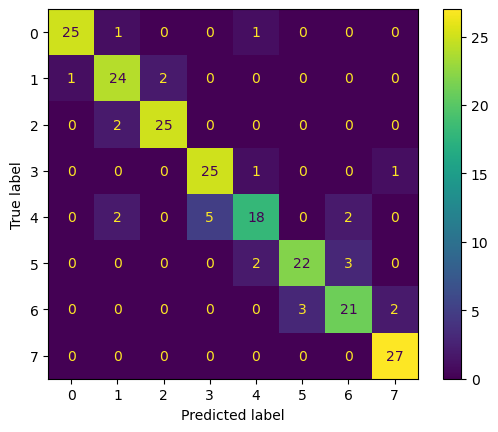

In [33]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [34]:
clf.predict_proba(X_mix1).argsort()[:,:2]

array([[1, 2],
       [1, 5],
       [5, 7],
       [7, 2],
       [5, 7],
       [7, 2],
       [5, 7],
       [2, 5],
       [5, 7],
       [7, 5],
       [5, 6],
       [5, 6],
       [4, 5],
       [5, 7],
       [4, 5],
       [7, 2],
       [3, 4],
       [3, 4],
       [5, 7],
       [5, 7],
       [5, 6],
       [4, 5],
       [4, 6],
       [5, 7],
       [7, 5],
       [7, 5],
       [5, 2],
       [5, 6],
       [4, 5],
       [5, 7],
       [2, 5],
       [6, 7],
       [5, 6],
       [2, 5],
       [4, 5],
       [2, 5],
       [7, 5],
       [4, 5],
       [4, 5],
       [6, 7],
       [5, 6],
       [4, 5],
       [2, 7],
       [2, 7],
       [7, 5],
       [0, 4],
       [0, 4],
       [0, 4],
       [4, 5],
       [5, 6],
       [4, 5],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [5, 6],
       [2, 5],
       [5, 6],
       [5, 6],
       [2, 5],
       [4, 5],
       [1, 2],
       [1, 2],
       [1, 2],
       [4,

In [35]:
clf.predict_proba(X_mix2).argsort()[:,:2]

array([[3, 4],
       [4, 5],
       [4, 5],
       [2, 4],
       [4, 5],
       [4, 5],
       [0, 5],
       [3, 5],
       [0, 3],
       [2, 5],
       [2, 5],
       [2, 5],
       [2, 5],
       [2, 3],
       [4, 5],
       [5, 6],
       [5, 7],
       [5, 7],
       [4, 5],
       [4, 5],
       [4, 5],
       [3, 4],
       [5, 6],
       [3, 4],
       [4, 5],
       [5, 6],
       [4, 5],
       [4, 5],
       [3, 4],
       [5, 4],
       [5, 7],
       [5, 4],
       [0, 3],
       [2, 3],
       [3, 4],
       [5, 6],
       [4, 5],
       [5, 6],
       [5, 6],
       [4, 5],
       [5, 6],
       [4, 5],
       [4, 5],
       [3, 4],
       [4, 5],
       [5, 4],
       [5, 4],
       [0, 2],
       [0, 2],
       [0, 2],
       [5, 3],
       [3, 5],
       [3, 5],
       [3, 4],
       [5, 7],
       [5, 7],
       [5, 4],
       [5, 7],
       [5, 7],
       [4, 5],
       [4, 5],
       [3, 5],
       [5, 7],
       [5, 7],
       [2, 5],
       [2, 5],
       [5,